# Human Pose Estimation - Part 4

# Human Keypoint Estimation - Model Training

## Download COCO Dataset

In [0]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip','train2017.zip',] 

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished unzipping val2017.zip
Finished downloading train2017.zip . Starting to unzip.
Finished unzipping train2017.zip
Done transferring all datasets


## Dataset Provider

In [0]:
# initialization
import numpy as np
import pandas as pd
import torch
import json
from PIL import Image
from scipy.io import loadmat
from matplotlib.pyplot import imshow, show
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import gaussian_filter



In [0]:
# Dataset provider
class KeyPoseDataset(Dataset):
    def __init__(self, path_to_annotations, base_img_path, transform=None):

        annotation_json = json.load(open(path_to_annotations,'rb'))
        self.annotations = annotation_json['annotations']        
        self.base_img_path = base_img_path
        self.transform = transform
        
        # Input image is 192x256
        self.input_width = 192
        self.input_height = 256

        # The heatmap is 4x smaller (48x64)
        self.heatmap_width = 48
        self.heatmap_height = 64
        self.nr_joints = 17
        
        print("clean database")
        self.annotations = self.clean_db(self.annotations)
        print("DONE - total nr samples: ", len(self.annotations))
        
    def clean_db(self,annotations):
        annotations_new = []
        
        for a in annotations:
            # remove iscrowd=True
            if a['iscrowd'] != 0:
                continue

            # remove images with no keypoints
            keypoints_list = np.asarray(a['keypoints'])
            keypoints = np.reshape(keypoints_list,(17,3))
            gt_validity = keypoints[:,2]>0
            if sum(gt_validity) == 0:
                continue

            # remove small bounding boxes
            x_start, y_start, box_w, box_h = a['bbox']
            if box_w < self.heatmap_width or box_h < self.heatmap_height:
                continue
            
            # add sample to dataset
            annotations_new.append(a)
        
        return annotations_new

    def __len__(self):
        return len(self.annotations)

    ## Generate and scale the input image
    def get_input_image(self,annotations):
        # Parse the annotations
        x_start, y_start, box_w, box_h = annotations['bbox']
        img_id = str(annotations['image_id'])    

        # Open to Image
        img_name = '000000000000'
        img_name = img_name[0:len(img_name) - len(img_id)] + img_id
        img = Image.open(self.base_img_path + '/' + img_name + '.jpg')
        
        # Rescale Input Image
        rescaled_img = img.resize((self.input_width,self.input_height), box=(x_start, y_start, x_start+box_w, y_start+box_h))
        rescaled_img = np.array(rescaled_img)
        
        if len(rescaled_img.shape) != 3:
            rescaled_img = np.stack((rescaled_img,)*3, axis=-1)
            
        # normalize input image
        mean=np.asarray([0.485, 0.456, 0.406])
        std=np.asarray([0.229, 0.224, 0.225])
        rescaled_img = rescaled_img.astype('float32')/255.0
        rescaled_img = (rescaled_img - mean) / std

        return torch.tensor(rescaled_img).permute(2,0,1).float()

    ## generate target heatmap
    def get_groundtruth_heatmap(self,annotations,gauss_sigma=2):
        # Parse the annotations
        x_start, y_start, box_w, box_h = annotations['bbox']
        keypoints_list = np.asarray(annotations['keypoints'])        

        # 3 columns, x,y,v
        keypoints = np.reshape(keypoints_list,(17,3))

        box_offset = np.asarray([x_start,y_start,0])
        box_dims = np.asarray([box_w,box_h,1])
        heatmap_dims = np.asarray([self.heatmap_width,self.heatmap_height,1])

        # rescale keypoints
        keypoints = np.round((keypoints - box_offset) * heatmap_dims / box_dims).astype(int)

        # generate gt heatmaps
        gt_heatmap = np.zeros((self.nr_joints,self.heatmap_height,self.heatmap_width))
        for j in range(self.nr_joints):
            if keypoints[j,2] > 0: # only plot valid points
                y = keypoints[j,0]
                x = keypoints[j,1]

                # skip, if x or y are out of bound
                if x<0 or y<0 or x>=self.heatmap_height or y>=self.heatmap_width:
                    keypoints[j,2] = 0
                    continue 

                # set joint location in heatmap
                gt_heatmap[j,x,y] = 1.0

                # apply gaussian
                gt_heatmap[j,:,:] = gaussian_filter(gt_heatmap[j,:,:], sigma=gauss_sigma, mode='constant', cval=0.0)

                # normalize to 1
                gt_heatmap[j,:,:] = gt_heatmap[j,:,:] / np.max(gt_heatmap[j,:,:]) 

        # get validity vector
        gt_validity = keypoints[:,2]>0

        return torch.tensor(gt_heatmap).float(), torch.tensor(gt_validity).float()

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        input_img = self.get_input_image(annotation)
        heatmap, validity = self.get_groundtruth_heatmap(annotation)
        
        return {
            'input_img': input_img, 
            'heatmap': heatmap,
            'validity': validity
        }

In [0]:
# initialize Datasets

train_keypose_dataset = KeyPoseDataset(path_to_annotations='./annotations/person_keypoints_train2017.json', base_img_path='./train2017')
train_dataloader = DataLoader(train_keypose_dataset, batch_size=32,
                        shuffle=True, num_workers=8)

val_keypose_dataset = KeyPoseDataset(path_to_annotations='./annotations/person_keypoints_val2017.json', base_img_path='./val2017')
val_dataloader = DataLoader(val_keypose_dataset, batch_size=32,
                        shuffle=False, num_workers=1)

clean database
DONE - total nr samples:  112283
clean database
DONE - total nr samples:  4798


## Model architecture

In [0]:
## Our own model architecture

# Expected accuracy ~0.6
class ConvDeconvNet(nn.Module):

    def __init__(self):
        super(ConvDeconvNet,self).__init__()
        #Convolution 1
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64, kernel_size=7,stride=2, padding=3)
        nn.init.normal_(self.conv1.weight, std=0.001)
        nn.init.constant_(self.conv1.bias, 0)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1= nn.ReLU()
        self.maxpool1= nn.MaxPool2d(kernel_size=2,stride=2)

        #Convolution 2
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128, kernel_size=5,stride=1, padding=2)
        nn.init.normal_(self.conv2.weight, std=0.001)
        nn.init.constant_(self.conv2.bias, 0)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2= nn.ReLU()
        self.maxpool2= nn.MaxPool2d(kernel_size=2,stride=2)
        
        #Convolution 3
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256, kernel_size=5,stride=1, padding=2)
        nn.init.normal_(self.conv3.weight, std=0.001)
        nn.init.constant_(self.conv3.bias, 0)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3= nn.ReLU()
        self.maxpool3= nn.MaxPool2d(kernel_size=2,stride=2)
        
        #Deconvolution 4
        self.deconv4 =nn.ConvTranspose2d(in_channels=256,out_channels=256,padding=1, output_padding=0,kernel_size=4, stride=2)
        nn.init.normal_(self.deconv4.weight, std=0.001)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4= nn.ReLU(inplace=True)
        
        #Deconvolution 5
        self.deconv5 =nn.ConvTranspose2d(in_channels=256,out_channels=256,padding=1, output_padding=0,kernel_size=4, stride=2)
        nn.init.normal_(self.deconv5.weight, std=0.001)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5= nn.ReLU(inplace=True)
        
        ### final layer declaration
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=17, kernel_size=1) # 17 joints -> out_channel=17
        nn.init.normal_(self.conv6.weight, std=0.001)
        nn.init.constant_(self.conv6.bias, 0)
        
    def forward(self,x):
        # conv layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        # deconv layer
        x = self.deconv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        
        x = self.deconv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        
        # final layer
        x = self.conv6(x)
        return(x)

In [0]:
## Resnet50 Architecture

# Expected accuracy ~0.75

# pytorch resnet implementation
# https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html

import torch
import torch.nn as nn
from torch.utils.model_zoo import load_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetPose(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNetPose, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        
        ### not needed
        #self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
                    
                    
        ### deconvolutional layers declaration
        self.deconv5 =nn.ConvTranspose2d(in_channels=2048,out_channels=256,padding=1, output_padding=0, kernel_size=4, stride=2)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5= nn.ReLU(inplace=True)
        
        self.deconv6 =nn.ConvTranspose2d(in_channels=256,out_channels=256,padding=1, output_padding=0,kernel_size=4, stride=2)
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6= nn.ReLU(inplace=True)
        
        self.deconv7 =nn.ConvTranspose2d(in_channels=256,out_channels=256,padding=1, output_padding=0,kernel_size=4, stride=2)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7= nn.ReLU(inplace=True)
        
        ### final layer declaration
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=17, kernel_size=1) # 17 joints -> out_channel=17
        
        
        ### init weights
        self.init_weights()


    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)
      

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        ### deconvolution layers
        x = self.deconv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        
        x = self.deconv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        
        x = self.deconv7(x)
        x = self.bn7(x)
        x = self.relu7(x)
        
        ### final layer
        x = self.conv8(x)

        return x
      
    def init_weights(self):
        
        # init deconv layers
        nn.init.normal_(self.deconv5.weight, std=0.001)
        nn.init.constant_(self.deconv5.bias, 0)
        nn.init.constant_(self.bn5.weight, 1)
        nn.init.constant_(self.bn5.bias, 0)
        
        nn.init.normal_(self.deconv6.weight, std=0.001)
        nn.init.constant_(self.deconv6.bias, 0)
        nn.init.constant_(self.bn6.weight, 1)
        nn.init.constant_(self.bn6.bias, 0)
        
        nn.init.normal_(self.deconv7.weight, std=0.001)
        nn.init.constant_(self.deconv7.bias, 0)
        nn.init.constant_(self.bn7.weight, 1)
        nn.init.constant_(self.bn7.bias, 0)
        
        # init final layer
        nn.init.normal_(self.conv8.weight, std=0.001)
        nn.init.constant_(self.conv8.bias, 0)
      
      
def resnetpose_pretrained():
  
    model = ResNetPose(Bottleneck, [3, 4, 6, 3])
    
    # load pretrained weights
    state_dict = load_url(model_urls['resnet50'],progress=True)
    model.load_state_dict(state_dict,strict=False)
    return model
      

In [0]:
## initialize model

model = ConvDeconvNet() # uncomment this line for our own architecture
# model = resnetpose_pretrained() # uncomment this line for pretrained Resnet50

# check input and output dimensions
sample = next(iter(val_dataloader))
img = sample['input_img'][None,0]
print("input dims: ", img.shape)
print("output dims: ", model(img).shape)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 19.0MB/s]


input dims:  torch.Size([1, 3, 256, 192])
output dims:  torch.Size([1, 17, 64, 48])


## Loss Function

In [0]:
# Loss function
def custom_l2_loss_closure(mse_loss_fn):
    # We want to zero out the loss for when no label was provided in the target heatmap
    # We can achieve this by multiply the validity tensor with the pred 
    
    def custom_l2_loss(pred,target,validity):
        v = validity.unsqueeze(2).unsqueeze(2)
        pred = pred * v
        target = target * v
        return mse_loss_fn(pred, target)
    
    return custom_l2_loss

loss_fn = custom_l2_loss_closure(mse_loss_fn=torch.nn.MSELoss())

## PCK Accuracy

In [0]:
# ORIGINAL FROM HERE:
# https://github.com/microsoft/human-pose-estimation.pytorch/blob/715d29e55f59ae555116542e85ed7175d57120e6/lib/core/evaluate.py
# ------------------------------------------------------------------------------
# Copyright (c) Microsoft
# Licensed under the MIT License.
# Written by Bin Xiao (Bin.Xiao@microsoft.com)
# ------------------------------------------------------------------------------
# Calculates Percentage of Correct Key-points (PCK) accuracy
# A detected joint is considered correct if the distance between the predicted 
# and the true joint is within a certain threshold. 
 
import numpy as np

def get_max_preds(batch_heatmaps):
    '''
    get predictions from score maps
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    '''
    assert isinstance(batch_heatmaps, np.ndarray), \
        'batch_heatmaps should be numpy.ndarray'
    assert batch_heatmaps.ndim == 4, 'batch_images should be 4-ndim'

    batch_size = batch_heatmaps.shape[0]
    num_joints = batch_heatmaps.shape[1]
    width = batch_heatmaps.shape[3]
    heatmaps_reshaped = batch_heatmaps.reshape((batch_size, num_joints, -1))
    idx = np.argmax(heatmaps_reshaped, 2)
    maxvals = np.amax(heatmaps_reshaped, 2)

    maxvals = maxvals.reshape((batch_size, num_joints, 1))
    idx = idx.reshape((batch_size, num_joints, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)

    preds[:, :, 0] = (preds[:, :, 0]) % width
    preds[:, :, 1] = np.floor((preds[:, :, 1]) / width)

    pred_mask = np.tile(np.greater(maxvals, 0.0), (1, 1, 2))
    pred_mask = pred_mask.astype(np.float32)

    preds *= pred_mask
    return preds, maxvals


def calc_dists(preds, target, normalize):
    preds = preds.astype(np.float32)
    target = target.astype(np.float32)
    dists = np.zeros((preds.shape[1], preds.shape[0]))
    for n in range(preds.shape[0]):
        for c in range(preds.shape[1]):
            if target[n, c, 0] > 1 and target[n, c, 1] > 1:
                normed_preds = preds[n, c, :] / normalize[n]
                normed_targets = target[n, c, :] / normalize[n]
                dists[c, n] = np.linalg.norm(normed_preds - normed_targets)
            else:
                dists[c, n] = -1
    return dists


def dist_acc(dists, thr=0.5):
    ''' Return percentage below threshold while ignoring values with a -1 '''
    dist_cal = np.not_equal(dists, -1)
    num_dist_cal = dist_cal.sum()
    if num_dist_cal > 0:
        return np.less(dists[dist_cal], thr).sum() * 1.0 / num_dist_cal
    else:
        return -1


def accuracy(output, target, hm_type='gaussian', thr=0.5):
    '''
    Calculate accuracy according to PCK,
    but uses ground truth heatmap rather than x,y locations
    First value to be returned is average accuracy across 'idxs',
    followed by individual accuracies
    '''
    idx = list(range(output.shape[1]))
    norm = 1.0
    if hm_type == 'gaussian':
        pred, _ = get_max_preds(output)
        target, _ = get_max_preds(target)
        h = output.shape[2]
        w = output.shape[3]
        norm = np.ones((pred.shape[0], 2)) * np.array([h, w]) / 10
    dists = calc_dists(pred, target, norm)

    acc = np.zeros((len(idx) + 1))
    avg_acc = 0
    cnt = 0

    for i in range(len(idx)):
        acc[i + 1] = dist_acc(dists[idx[i]])
        if acc[i + 1] >= 0:
            avg_acc = avg_acc + acc[i + 1]
            cnt += 1

    avg_acc = avg_acc / cnt if cnt != 0 else 0
    if cnt != 0:
        acc[0] = avg_acc
    return avg_acc

# Wrapper function to calculate accuracy for one batch
def get_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        sample_batched = next(iter(dataloader))
        input_img = sample_batched['input_img'].to('cuda')
        heatmap = sample_batched['heatmap'].to('cuda')
        validity = sample_batched['validity'].to('cuda')
        outputs = model(input_img)
        acc_val = accuracy(outputs.cpu().numpy(),heatmap.cpu().numpy())
            
    model.train()
    return acc_val

## Training Loop

In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Training Loop
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10
EXPERIMENTS_PATH="drive/My Drive/Manning/experiments/"

# function to store model checkpoint
def checkpoint_model(model, optimizer, epoch, batch):
    state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(state, EXPERIMENTS_PATH + "posenet_" + str(epoch) + "_" + str(batch) + '.pth')

# prepare model
model.cuda()
model.train()

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, [8], 0.1
)

# start training loop
for j in range(NUM_EPOCHS):
    for i_batch, sample_batched in enumerate(train_dataloader):

        input_img = sample_batched['input_img'].to('cuda')
        heatmap = sample_batched['heatmap'].to('cuda')
        validity = sample_batched['validity'].to('cuda')
        
        # Clear out accumulated gradients
        optimizer.zero_grad()
        
        output = model(input_img)
        loss = loss_fn(output, heatmap, validity) 
        
        loss.backward() # Compute gradients
        optimizer.step() # Update model parameters
        
        if i_batch % 100 == 0:
            
            acc_train = accuracy(output.detach().cpu().numpy(),heatmap.detach().cpu().numpy())
            acc_val = get_accuracy(model,val_dataloader)
            print("Epoch", j, "Batch", i_batch, "Training Loss: ", loss.item(), "Train Accuracy: ", acc_train, "Val Accuracy: ", acc_val)
        
        if i_batch % 500 == 0:        
            checkpoint_model(model, optimizer, j, i_batch)
        
    scheduler.step()
checkpoint_model(model, optimizer, j, i_batch)

Epoch 0 Batch 0 Training Loss:  0.0024765569251030684 Train Accuracy:  0.014011007911936702 Val Accuracy:  0.005294117647058823
Epoch 0 Batch 100 Training Loss:  0.0020163999870419502 Train Accuracy:  0.2660352960622524 Val Accuracy:  0.2604092032939237
Epoch 0 Batch 200 Training Loss:  0.0017210814403370023 Train Accuracy:  0.3914216770887917 Val Accuracy:  0.41087792054809236
Epoch 0 Batch 300 Training Loss:  0.001700685010291636 Train Accuracy:  0.4196971749992305 Val Accuracy:  0.511074028660237
Epoch 0 Batch 400 Training Loss:  0.0015956780407577753 Train Accuracy:  0.5358375534500103 Val Accuracy:  0.5227231962881206
Epoch 0 Batch 500 Training Loss:  0.0013762952294200659 Train Accuracy:  0.5723841775699361 Val Accuracy:  0.5756937423660837
Epoch 0 Batch 600 Training Loss:  0.001624325755983591 Train Accuracy:  0.5226707271298818 Val Accuracy:  0.5925981879337568
Epoch 0 Batch 700 Training Loss:  0.0013279193080961704 Train Accuracy:  0.5853852019643869 Val Accuracy:  0.568475029

## Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GROUNDTRUTH HEATMAP
Image:  (1, 3, 256, 192) float32 2.64 -2.117904
Heatmap:  (1, 17, 64, 48) float32 1.0 0.0
Validity:  (1, 17) float32


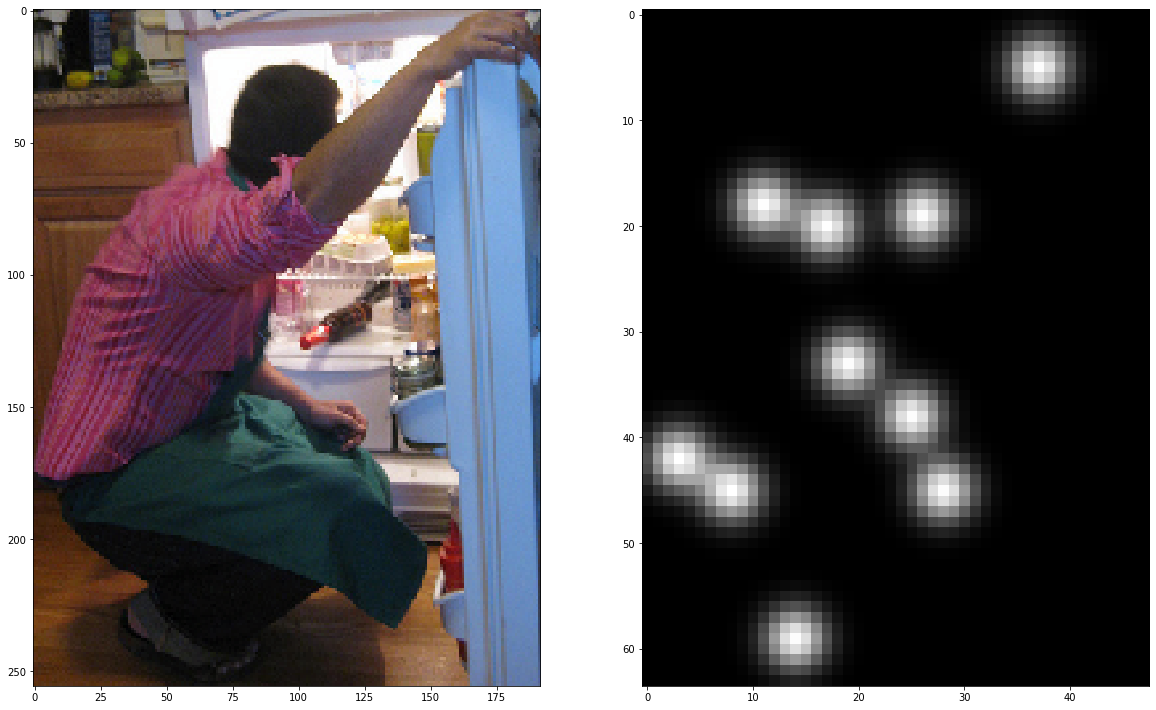

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTED HEATMAP
Image:  (1, 3, 256, 192) float32 2.64 -2.117904
Heatmap:  (1, 17, 64, 48) float32 0.97890335 -0.019752989
Validity:  (1, 17) float32


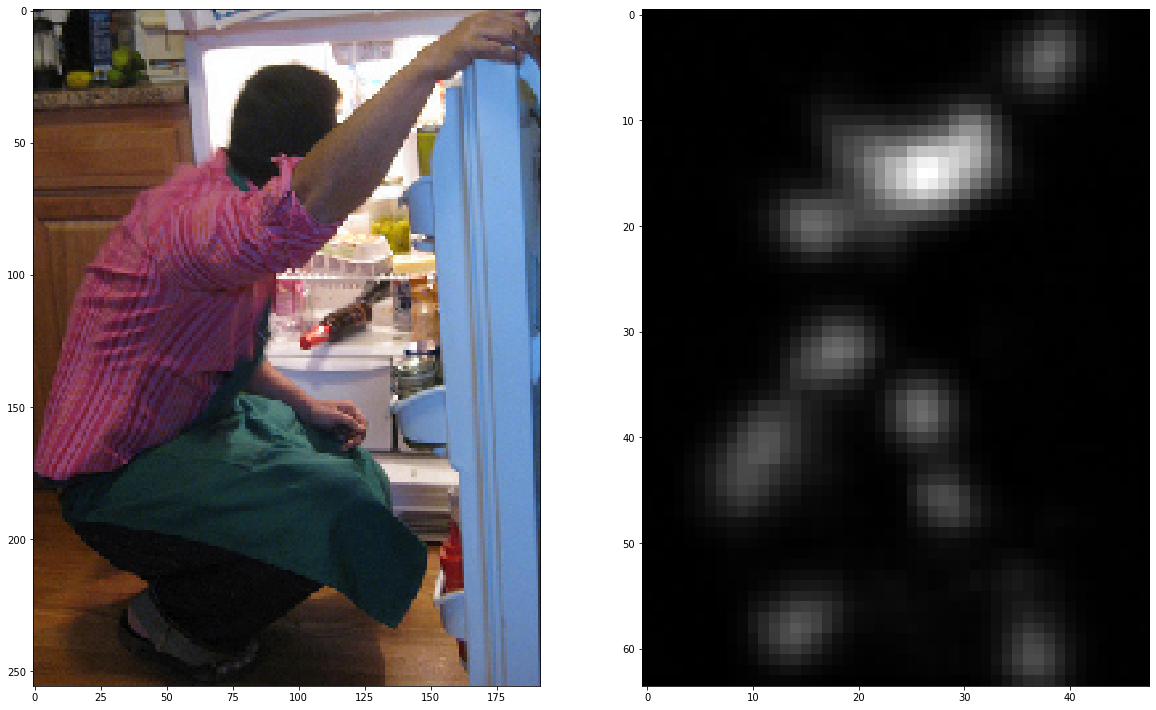

In [0]:
# heatmap plotting function
def plot_data(img_t,heatmap_t,validity_t):

  # convet to numpy
  img = img_t.cpu().numpy()
  heatmap = heatmap_t.cpu().numpy()
  validity = validity_t.cpu().numpy()
  
  # print stats
  print("Image: ", img.shape, img.dtype, np.max(img), np.min(img))
  print("Heatmap: ", heatmap.shape, heatmap.dtype, np.max(heatmap), np.min(heatmap))
  print("Validity: ", validity.shape, validity.dtype)
  
  # prepare data
  img = img[0].squeeze().transpose(1,2,0)
  mean=np.asarray([0.485, 0.456, 0.406])
  std=np.asarray([0.229, 0.224, 0.225])
  img = img*std + mean
  heatmap = np.sum(heatmap[0],axis=0)
  
  # plot data
  fig = plt.figure(2,figsize=(20,20))
  plt.gray()  # show the filtered result in grayscale
  ax1 = fig.add_subplot(121)  # left side
  ax1.imshow(img)
  ax2 = fig.add_subplot(122)  # right side
  ax2.imshow(heatmap)
  plt.show()

# get sample from validation set
sample_batched = next(iter(val_dataloader))
input_img = sample_batched['input_img'][None,0].to('cuda')
heatmap = sample_batched['heatmap'][None,0].to('cuda')
validity = sample_batched['validity'][None,0].to('cuda')

# run inference on model
model.eval()
with torch.no_grad():
  output = model(input_img)

# plot groundtruth heatmap
print ("GROUNDTRUTH HEATMAP")
plot_data(input_img,heatmap,validity)

# plot predicted heatmap
print ("PREDICTED HEATMAP")
plot_data(input_img,output,validity)
